In [5]:
import numpy as np
import os
import pyccl as ccl

import matplotlib.pyplot as plt
import corner
import seaborn
import pandas

import scipy.stats.qmc as qmc
import scipy.stats as stats
from scipy.interpolate import interp1d

from tqdm import trange, tqdm

from multiprocessing import Pool

import src.datamaker as datamaker
from importlib import reload
reload(datamaker)
reload(ccl)

<module 'pyccl' from '/home/b7009348/miniconda3/envs/cosymaml/lib/python3.11/site-packages/pyccl/__init__.py'>

### First we need to generate a range of distributions for different "surveys"

In [6]:
np.random.seed(14)
n_tasks = 10
gridsize = 50

task_means = np.random.uniform(0.8, 1.6, n_tasks)
task_vars = np.random.uniform(0.2, 0.6, n_tasks)

survey_pz = np.empty((n_tasks, gridsize-1))
survey_midpoints = np.empty((n_tasks, gridsize-1))
for i in range(n_tasks):
    
    survey_pz[i], survey_midpoints[i] = datamaker.gen_Pz_base(
        task_means[i],
        task_vars[i],
        gridsize
        )

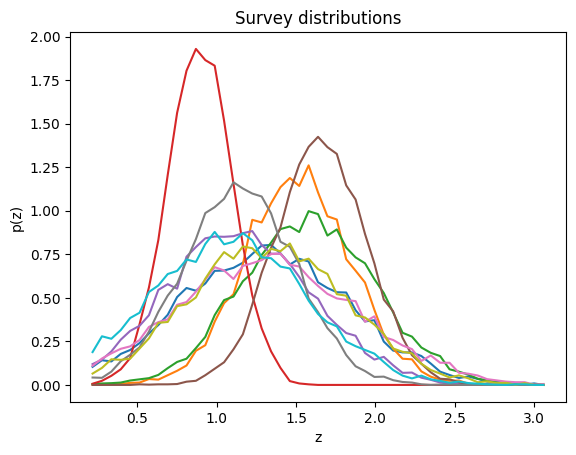

In [7]:
# Plot a subset of the survey distributions
plt.figure()
for i in range(n_tasks):
    if i % 1 == 0:
        plt.plot(survey_midpoints[i], survey_pz[i])
plt.title("Survey distributions")
plt.xlabel("z")
plt.ylabel("p(z)")
plt.savefig("survey_distributions.pdf", bbox_inches="tight")

### The next step is to sample possible realisations of each distribution using a Logistic Gaussian Process (thanks Markus)

In [217]:
# Total samples will qrd_samples * cosmology_samples
n_samples = 2**5
print("Number of samples: ", n_samples)

true_means = np.empty(n_tasks)
qrd_pz = np.empty((n_tasks, n_samples, gridsize-1))

for i in trange(n_tasks):
    qrd_pz[i], true_means[i] = datamaker.gen_Pz_samples(
                                        survey_pz[i],
                                        survey_midpoints[i],
                                        seed=14,
                                        shift=0.01,
                                        qrd_samples=n_samples
                                        )

    

Number of samples:  32


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


Text(0.5, 1.0, 'QMC samples of survey distribution 6')

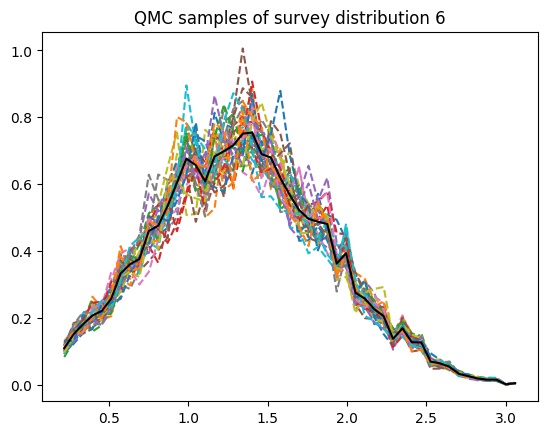

In [225]:
task = 6

plt.figure()
for i in range(n_samples):
    plt.plot(survey_midpoints[task], qrd_pz[task, i], ls='--')

plt.plot(survey_midpoints[task], survey_pz[task], color='black')
plt.title("QMC samples of survey distribution %d"%task)

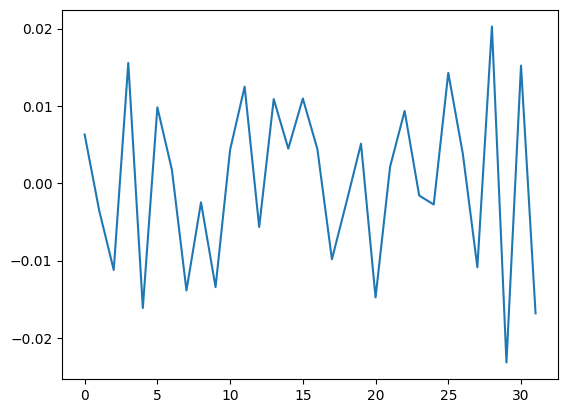

In [227]:
# Compute the shifts in the means
shifts = np.empty((n_tasks, n_samples))
plt.figure()
for i in range(n_tasks):
    for j in range(n_samples):
        mean = np.trapz(qrd_pz[i, j]*survey_midpoints[i], survey_midpoints[i])
        shifts[i, j] = mean - true_means[i]

    # Plot the shifts
    if i % n_samples/10 == 0:
        plt.plot(shifts[i], ls='-')

### We will have 32 cosmological parameter samples so the total number of data-points is 1024

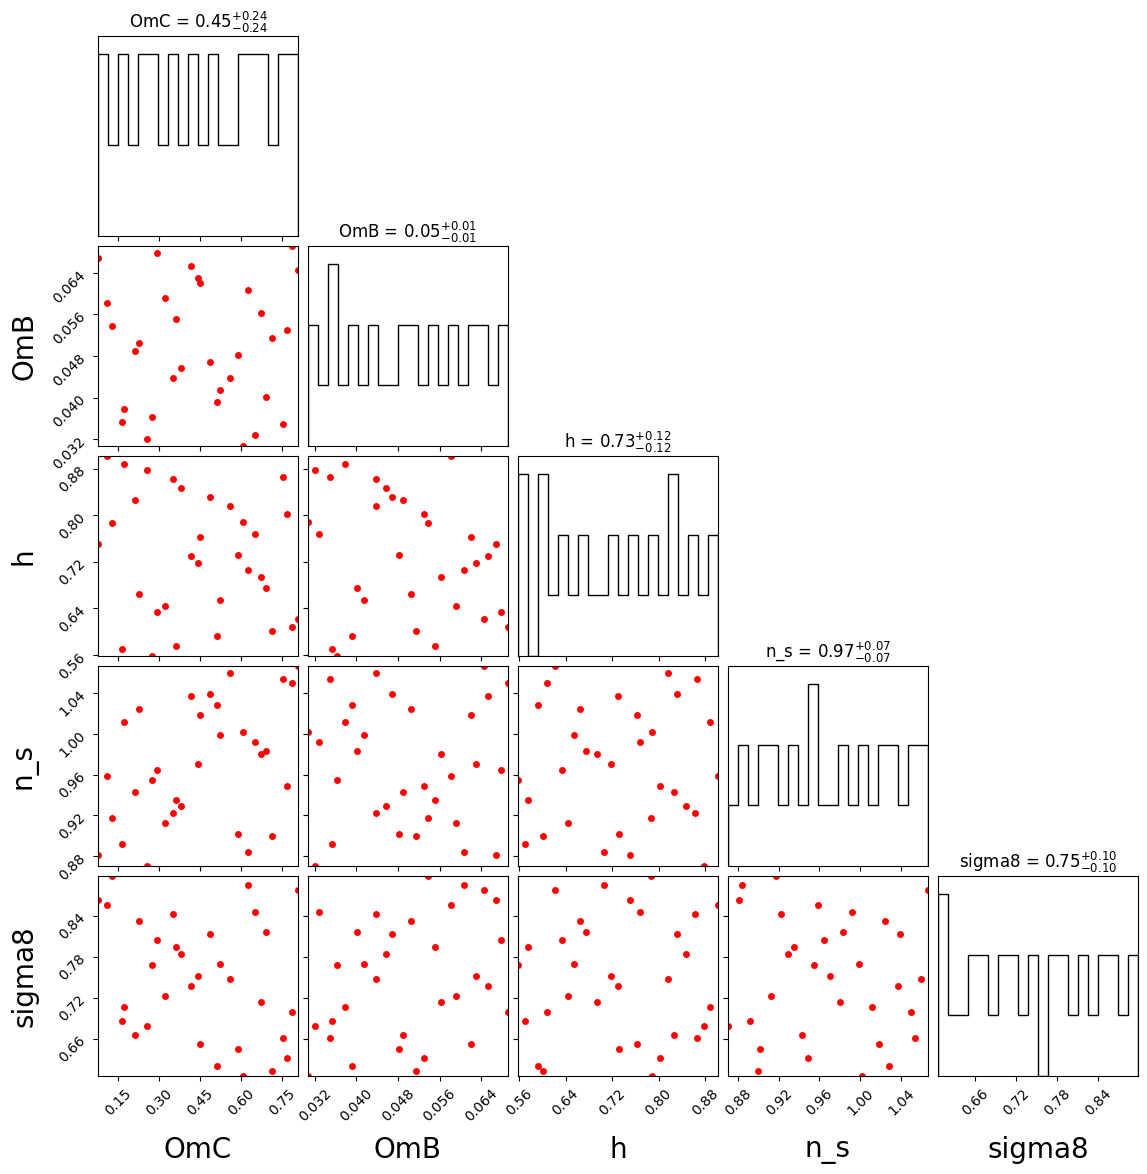

In [228]:
# Priors from DES Y3 Cosmic shear fits
OmM = np.array([0.1, 0.9])
OmB = np.array([0.03, 0.07])
OmC = OmM - OmB

h = np.array([0.55, 0.91])
n_s = np.array([0.87, 1.07])
sigma8 = np.array([0.6, 0.9])

# Generate the cosmology hypercube example (we will regenerate this each time for each task)
cosmo_hypercube = datamaker.gen_hypercube(OmC, OmB, h, n_s, sigma8, n_samples)

# plot the hypercube samples
param_list = ['OmC', 'OmB', 'h', 'n_s', 'sigma8']
df = pandas.DataFrame(cosmo_hypercube, columns=param_list)
# Use corner plot to visualize
corner.corner(df, labels=[string for string in param_list], show_titles=True,
              plot_contours=False, plot_density=False, plot_datapoints=True,
              data_kwargs={'alpha': 1,'color': 'red','ms' : 5}, label_kwargs={'fontsize': 20})
plt.show()

### Now we have a set of 100 survey distributions with different realisations
The next step is to combine our sampled cosmologies and distributions to generate the training examples

In [229]:
# First we will collate the training data inputs together
# We will have to do this for each task

# We have n_tasks with qrd_samples for each task
inputs = 6
X_train = np.empty((n_tasks, n_samples, inputs))

for i in trange(n_tasks):
    # Generate new Hypercube for each task to randomise the cosmology samples
    cosmo_hypercube = datamaker.gen_hypercube(OmC, OmB, h, n_s, sigma8, n_samples)
    for j in range(inputs):
        if j != inputs-1:
            X_train[i, :, j] = cosmo_hypercube[:, j]
        else:
            X_train[i, :, j] = shifts[i, :]

100%|██████████| 10/10 [00:00<00:00, 1457.47it/s]


In [231]:
ell_bins = np.unique(np.geomspace(2, 60000, 31).astype(int))
print(len(ell_bins))

30


In [223]:
# Finally, compute Cell for different cosmolgies and redshifts
Y_train = np.empty((n_tasks, n_samples, 30))
for i in trange(n_tasks):
    for j in range(n_samples):
        cosmo = ccl.Cosmology(
            Omega_c=X_train[i, j, 0],
            Omega_b=X_train[i, j, 1],
            h=X_train[i, j, 2],
            n_s=X_train[i, j, 3],
            sigma8=X_train[i, j, 4],
        )

        # Get the pz for this task and sample
        pz = qrd_pz[i, j]
        z = survey_midpoints[i]

        # Upsample the pz to ensure accurate calculation of Cgg
        z_up = np.linspace(z[0], z[-1], 300)
        interpolator = interp1d(z, pz, kind='cubic')
        pz_up = interpolator(z_up)

        Y_train[i, j] = datamaker.gen_Cgg_autocorr(cosmo, ell_bins, z_up, pz_up)

100%|██████████| 10/10 [02:04<00:00, 12.49s/it]


In [240]:
((20*1024) / 320) * (2.3 / 60)

2.453333333333333

0